# Abstractive Text Summarization - LSTM GloVe

### Importing Basic libraries

In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K 
from tensorflow.python.keras.layers import Layer


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 919 kB/s            


### Importing Data

In [4]:
data = pd.read_excel('../input/inshorts-news-data/Inshorts Cleaned Data.xlsx')

In [5]:
data.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)
data.head()

,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...


### Punctuation and Stopwords Removal

In [7]:
stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower()
    
    tokens = [w for w in text.split() if not w in stop_words]
    text = " ".join(tokens)
    text = text.replace("'s",'')
    text = text.replace(".",'')
    text = re.sub(r'\(.*\)','',text)
    text = re.sub(r'[^a-zA-Z0-9. ]',' ',text)
    text = re.sub(r'\.','. ',text)
    text = re.sub(r'\s+', ' ', text)
    return text


### Lemmatization

In [8]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

In [9]:
data.rename(columns={'Headline': 'headlines', 'Short': 'text'}, inplace=True)

In [10]:
original_text = str(data['text'][0])
original_headline = str(data['headlines'][0])

In [11]:
processed_text = data['text'].apply(preprocess)
data['text'] = processed_text.apply(lemmatize_text)
data['headlines'] = data['headlines'].apply(lambda x : '_START_ '+ x + ' _END_')

for i in range(2):
    print('Summary:', data['headlines'][i],'Text:', data['text'][i], sep='\n')
    print()

Summary:
_START_ 4 ex-bank officials booked for cheating bank of ₹209 crore _END_
Text:
cbi saturday book four former official syndicate bank six other cheat forgery criminal conspiracy cause 209 crore loss state run bank accuse availed home loan credit syndicate bank basis forge fabricate document fund fraudulently transfer company own accuse person

Summary:
_START_ Supreme Court to go paperless in 6 months: CJI _END_
Text:
chief justice js khehar say supreme court go paperless six seven month bid save fund make judiciary eco friendly say apex court collect record electronically low court high court need file hard copy



### Sample Input    

In [12]:
print("\nORIGINAL")
print(original_text)
print(original_headline)

print("\nREGEX CLEANING AND STOPWORD REMOVAL:")
print(processed_text[0])
# print(brief_cleaned_summary[0])

print("\nLEMMATIZATION + START AND END TOKEN")
print(data['text'][0])
print(data['headlines'][0])


ORIGINAL
The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons.
4 ex-bank officials booked for cheating bank of ₹209 crore

REGEX CLEANING AND STOPWORD REMOVAL:
cbi saturday booked four former officials syndicate bank six others cheating forgery criminal conspiracy causing 209 crore loss state run bank accused availed home loans credit syndicate bank basis forged fabricated documents funds fraudulently transferred companies owned accused persons

LEMMATIZATION + START AND END TOKEN
cbi saturday book four former official syndicate bank six other cheat forgery criminal conspiracy cause 209 crore loss state run bank accuse availed home loan credit syndicate bank basis 

In [13]:
headlines_length = [len(x.split()) for x in data.headlines]
text_length = [len(x.split()) for x in data.text]

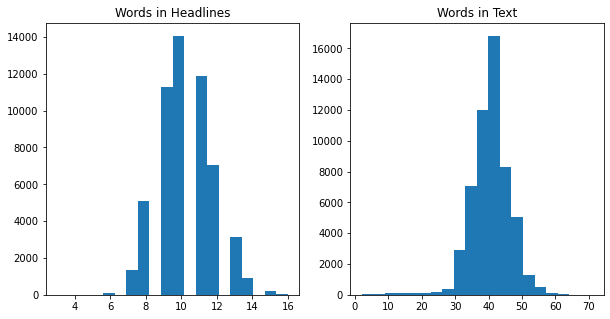

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.hist(headlines_length, bins = 20)
ax2.hist(text_length, bins = 20)

ax1.title.set_text("Words in Headlines")
ax2.title.set_text("Words in Text")
plt.show()

### Embedding Matrix from Glove


In [15]:
glove_size = 300
f = open('../input/glove42b300dtxt/glove.42B.300d.txt')

In [16]:
embeddings_index = dict()
for line in f:
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
f.close()

In [3]:
words_source_train = []
for i in data['text'] :
  words_source_train.extend(i.split(' '))

print("all the words in the corpus", len(words_source_train))
words_source_train = set(words_source_train)
print("the unique words in the corpus", len(words_source_train))
inter_words = set(embeddings_index.keys()).intersection(words_source_train)
print("The number of words that are present in both glove vectors and our corpus are {} which \
is nearly {}% ".format(len(inter_words), np.round((float(len(inter_words))/len(words_source_train))
*100)))

words_corpus_source_train = {}
words_glove = set(embeddings_index.keys())
for i in words_source_train:
  if i in words_glove:
    words_corpus_source_train[i] = embeddings_index[i]
print("GloVe length", len(words_corpus_source_train))

all the words in the corpus 2235816 
the unique words in the corpus 62368 
The number of words that are present in both glove vectors and our corpus are 52505 which is nearly 84.0% 
GloVe length 52505


In [18]:
print(list(words_source_train - inter_words)[:20])

['', 'heptulla', 'cruegar', 'governmentis', 'resynchronise', 'crorebut', 'mdshami11', 'dinitramide', 'aptenoperissus', 'wx06a', 'majli', 'yallamma', 'taenk', 'nupcome', 'biharha', 'gangajalin', 'egotiating', 'djokernole', 'dindoshi', 'smaile']


In [19]:
def num(text):
  words = [w for w in text.split() if not w in inter_words]
  return len(words)

data['unique_words'] = data['text'].apply(num)

In [20]:
data['unique_words'].value_counts()

0    40642
1     9409
2     3389
3     1155
4      333
5      124
6       41
7        8
8        2
9        1
Name: unique_words, dtype: int64

In [21]:
data = data[data['unique_words'] < 4]
data.reset_index(inplace=True, drop=True)

In [22]:
data

,headlines,text,unique_words
0,_START_ 4 ex-bank officials booked for cheatin...,cbi saturday book four former official syndica...,0
1,_START_ Supreme Court to go paperless in 6 mon...,chief justice js khehar say supreme court go p...,0
2,"_START_ At least 3 killed, 30 injured in blast...",least three people kill include policeman 30 o...,1
3,_START_ Why has Reliance been barred from trad...,mukesh ambani lead reliance industry 2007 ril ...,0
4,_START_ Was stopped from entering my own studi...,tv news anchor arnab goswami say tell could pr...,0
...,...,...,...
54590,_START_ Sensex loses 400 points to hit 52-week...,track weak cue asian market benchmark sensex w...,1
54591,_START_ China to inject $91 bn into the money ...,amid grow concern china 39 s economic growth r...,0
54592,_START_ Ghulam Ali set to make acting debut in...,pakistani ghazal singer ghulam ali soon make a...,1
54593,_START_ IS acknowledges death of Jihadi John: ...,islamic state acknowledge death 39 jihadi john...,1


### Splitting Data

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data['text'], data['headlines'], test_size = 0.2, random_state = 20)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size = 0.5, random_state = 20)

In [24]:
max_length_x = max(text_length)
max_length_y = max(headlines_length)

### Tokenization

In [25]:
x_t = Tokenizer()
x_t.fit_on_texts(data['text'] + data['headlines'])
x_vocab_size = len(x_t.word_index) + 1

encoded_xtrain = x_t.texts_to_sequences(X_train)
encoded_xval = x_t.texts_to_sequences(X_val)
encoded_xtest = x_t.texts_to_sequences(X_test)

padded_xtrain = pad_sequences(encoded_xtrain, maxlen=max_length_x, padding='post')
padded_xval = pad_sequences(encoded_xval, maxlen=max_length_x, padding='post')
padded_xtest = pad_sequences(encoded_xtest, maxlen=max_length_x, padding='post')

In [26]:
y_t = Tokenizer()
y_t.fit_on_texts(data['headlines'])
y_vocab_size = len(y_t.word_index) + 1

encoded_ytrain = y_t.texts_to_sequences(y_train)
encoded_yval = y_t.texts_to_sequences(y_val)
encoded_ytest = y_t.texts_to_sequences(y_test)

padded_ytrain = pad_sequences(encoded_ytrain, maxlen=max_length_y, padding='post')
padded_yval = pad_sequences(encoded_yval, maxlen=max_length_y, padding='post')
padded_ytest = pad_sequences(encoded_ytest, maxlen=max_length_y, padding='post')

### Creation of Embedding Matrix

In [27]:
print('Loaded %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((x_vocab_size, glove_size))
for word, i in x_t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Loaded 1917494 word vectors.


### Building Model

In [29]:
latent_dim=500

K.clear_session() 

encoder_inputs = Input(shape=(max_length_x,)) 
enc_emb = Embedding(x_vocab_size, glove_size, weights=[embedding_matrix],input_length=max_length_x, trainable=False)(encoder_inputs) 

# Encoder 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(x_vocab_size, glove_size, weights=[embedding_matrix],input_length=max_length_x, trainable=False) 
dec_emb = dec_emb_layer(decoder_inputs) 

# LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_outputs) 

model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
print(model.summary())

2022-01-11 15:35:05.861235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 15:35:05.862506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 15:35:05.863303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 15:35:05.864122: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 71)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 71, 300)      20596200    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 71, 500), (N 1602000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [30]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
checkpoint_filepath = './model.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True, save_freq = "epoch")
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
history=model.fit(
    [padded_xtrain,padded_ytrain[:,:-1]], 
    padded_ytrain.reshape(padded_ytrain.shape[0],padded_ytrain.shape[1], 1)[:,1:], 
    epochs=30,
    batch_size=512, 
    validation_data=([padded_xval,padded_yval[:,:-1]], padded_yval.reshape(padded_yval.shape[0],padded_yval.shape[1], 1)[:,1:]), 
    callbacks=[model_checkpoint_callback])

2022-01-11 15:35:15.542625: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-01-11 15:35:20.975638: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


86/86 [==============================] - 43s 426ms/step - loss: 5.3491 - val_loss: 4.8141


2022-01-11 15:35:58.866996: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 82384800 exceeds 10% of free system memory.
2022-01-11 15:35:59.120752: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 82384800 exceeds 10% of free system memory.
2022-01-11 15:35:59.410501: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 58778000 exceeds 10% of free system memory.


Epoch 2/30
86/86 [==============================] - 35s 413ms/step - loss: 4.7386 - val_loss: 4.6932
Epoch 3/30
86/86 [==============================] - 35s 413ms/step - loss: 4.6028 - val_loss: 4.6067
Epoch 4/30
86/86 [==============================] - 36s 414ms/step - loss: 4.4891 - val_loss: 4.5356
Epoch 5/30
86/86 [==============================] - 36s 414ms/step - loss: 4.3742 - val_loss: 4.4673
Epoch 6/30
86/86 [==============================] - 36s 415ms/step - loss: 4.2477 - val_loss: 4.3794
Epoch 7/30
86/86 [==============================] - 36s 414ms/step - loss: 4.1063 - val_loss: 4.3196
Epoch 8/30
86/86 [==============================] - 36s 413ms/step - loss: 3.9629 - val_loss: 4.2163
Epoch 9/30
86/86 [==============================] - 36s 414ms/step - loss: 3.8261 - val_loss: 4.1590
Epoch 10/30
86/86 [==============================] - 36s 414ms/step - loss: 3.6929 - val_loss: 4.0879
Epoch 11/30
86/86 [==============================] - 36s 414ms/step - loss: 3.5627 - val_l

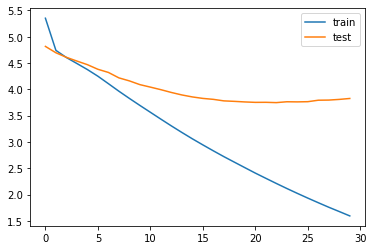

In [31]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

### Inference

In [34]:
reverse_target_word_index = y_t.index_word 
reverse_source_word_index = x_t.index_word 
target_word_index = y_t.word_index

In [35]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_length_x,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [36]:
def decode_sequence(input_seq):
    input_seq= input_seq.reshape(1,max_length_x)
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
  
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token
 
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_length_y-1)):
                stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c

    return decoded_sentence

In [37]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [38]:
print("Review:",seq2text(padded_xtest[5]))
print("Original summary:",seq2summary(padded_ytest[5]))
print("Predicted summary:",decode_sequence(padded_xtest[5]))


Review: usa become first nation register gold medal rio olympics 2016 19 year old virginia thrasher gold 10 metre air rifle day one event hold saturday thrasher finish ahead china 39 s du li yi sile silver bronze medal open china 39 s medal tally event
Original summary: usa wins first gold medal of rio olympics 2016 
Predicted summary:  usa wins gold medals at world championships c 39 shi



In [39]:
print("Review:",seq2text(padded_xtest[32]))
print("Original summary:",seq2summary(padded_ytest[32]))
print("Predicted summary:",decode_sequence(padded_xtest[32]))


Review: we base startup shalgi design studio develop smart luggage 39 g ro 39 feature all terrain wheel inbuilt tablet stand charge station two usb port g ro come 360 revolvable wheel luggage location tracker 23 000 mah battery luggage capable charge tablet laptop smartphone last long enough charge smartphone 10 time 
Original summary: us startup develops smart luggage 39 g ro 39 
Predicted summary:  startup makes portable that with touchscreen inbuilt



In [40]:
print("Review:",seq2text(padded_xtest[69]))
print("Original summary:",seq2summary(padded_ytest[69]))
print("Predicted summary:",decode_sequence(padded_xtest[69]))


Review: first volume comic series 39 the adventure asterix 39 release sale hindi publishing house 39 om book international 39 comic 39 ast rix le gaulois 39 available title 39 gaulwasi ast rix 39 comic strip originally write french ren goscinny illustrate albert aleandro uderzo translate puneet gupta dipa chaudhuri 
Original summary: 1st volume of 39 astérix 39 comic released in hindi 
Predicted summary:  1st tv of 39 the jungle book 39 released



### Evaluation

In [41]:
def BLEU_Score(y_test, y_pred):
    references = [[seq2summary(y_test).split(" ")]]
    candidates = [decode_sequence(y_pred.reshape(1,max_length_x)).split(" ")]
    return corpus_bleu(references, candidates)

In [42]:
from nltk.translate.bleu_score import corpus_bleu
scores=[]
for i in range(0,500):
    scores.append(BLEU_Score(padded_ytest[i],padded_xtest[i]))
    
print(np.mean(scores))

0.6016678594297942
